# 【第２回目　課題２】PyTorchを使った深層学習 (2): 畳み込み編
    
課題１に引き続いてPytorchのSequential modelを用いて，前回の課題２のフィルタ学習を行ってみます．
エッジ検出のフィルタを3層の畳み込みネットワークで学習してみます．

入出力は画像ですが，基本的に出力回帰問題ですので，課題１と同じで，最小２乗誤差を用いて学習します．

In [1]:
import numpy as np
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# 必要があれば，GPU IDを指定します．
# IEDは 8GPUなので必ず指定してください．
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "7"

次に画像の読み込みに必要なPIL, 表示に必要なmatplotlibなどのモジュールを読み込みます．

In [2]:
from skimage import feature,filters
from PIL import Image
import os
import sys

%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

画像を読み込んで，エッジ画像を生成して，学習データを作ります．Canny法でエッジ抽出します．
use_edge=Falseとすれば，目標画像を濃淡画像にするので，濃淡化フィルタの学習になります．

なお，PyTorchでは，テンソルは Batch, Channel, Height, Width の順番に表現しますので，
読み込んだ画像を
img=img.transpose(2,0,1) で HWC から CHW へ変換して，さらに batchの軸を
gt=gt[np.newaxis, ...]
で追加します．

(3, 240, 320) (1, 240, 320)


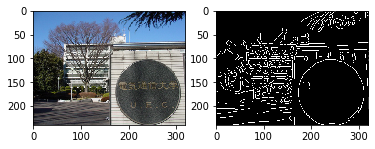

In [3]:
img_org = Image.open('image/uec.jpeg').resize((320,240))
img = np.array(img_org, dtype=np.uint8)
grey = np.array(img_org.convert('L'), dtype=np.uint8)
edge = feature.canny(grey,sigma=2)  # Canny でエッジ抽出
# edge = filters.sobel(grey) # Sobel でエッジ抽出
edge = edge * 255

# エッジ検出フィルタ，グレースケール化フィルタの切り替え
use_edge=True  # Falseだとグレースケール化フィルタの学習
if use_edge:
    gt=edge
else:
    gt=grey

plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(gt,cmap="gray")

img=img.transpose(2,0,1) # HWC から CHW へ変換
gt=gt[np.newaxis, ...]

print(img.shape,gt.shape)

読み込んだ画像と変換した画像を，numpy形式に変換します．
(c,h,w) c:チャネル, h:高さ, w:幅　のサイズの3次元配列にします．
PyTorch の標準の形式は，(c,h,w) です.

ここでは画像は320x240で，入力はカラーなので，
input: (3,240,320)
output: (1,240,320)
の大きさです．

In [4]:
# 画素値が [-1,1) の範囲の値になるように変換
# Keras は (h,w,c)が標準ですので，前回の
#input  = (np.asarray(img, dtype=np.float32).transpose(2,0,1)-128)/128.0 の transposeが不要になります．
input  = (np.asarray(img, dtype=np.float32)-127.5)/127.5
output = (np.asarray(gt, dtype=np.float32)-127.5)/127.5

# Keras では，convolution へ与えるデータは最初にbatchの次元を追加して４次元テンソルで表現します．
# 画像１枚での学習なので，batch は 1 です．
# さらに，torch形式のtensorへ変換します．
input = torch.from_numpy(input[np.newaxis, ...])     # (3, 240,320) -> (1,3, 240,320)
output = torch.from_numpy(output[np.newaxis, ...])   # (1, 240,320) -> (1,1, 240,320)

input.max(),input.min(),output.shape,input.shape

(tensor(1.),
 tensor(-1.),
 torch.Size([1, 1, 240, 320]),
 torch.Size([1, 3, 240, 320]))

In [5]:
#torchを使うと簡単に正規化できる

from torchvision import transforms as transforms
# https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html

preprocess = transforms.Compose([
#     transforms.Resize(224),
#     transforms.CenterCrop(224),
    transforms.ToTensor(),# -1 ~ 1
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )#  output[channel] = (input[channel] - mean[channel]) / std[channel]
    ]
)

img_org = Image.open('image/uec.jpeg').resize((320,240))
print('preprocessed_shape',preprocess(img_org).shape)
input = preprocess(img_org).unsqueeze(0)
print('input_shape',input.shape)

preprocessed_shape torch.Size([3, 240, 320])
input_shape torch.Size([1, 3, 240, 320])


mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]  
ImageNet という画像分類データセットの RGB の平均と標準偏差。  
torchvision の事前学習済みモデルを利用するならこれを使う必要がありますが、自作のモデルでゼロから学習するなら、自分のデータセットの平均と分散を計算しておいてそれを使うほうがいい。

In [6]:
# 学習途中のlossなどのグラフ表示を行う ShowGraphを定義
# グラフ表示で必要なので，コンストラクタで，model, 最大エポック数 を受け取っておく．
# model は，学習途中のパラメータを用いて， y=f(x)を描画するのに必要．
class ShowGraph:
    def __init__(self,model,max_epoch,test_img):
        # 表示エリアの設定
        self.fig=plt.figure(figsize=(8,4))
        self.fig1 = self.fig.add_subplot(121)
        self.fig1.axis([0, max_epoch, 0, 1])
        self.fig1.set_title('loss')
        self.fig1.set_ylabel('loss')
        self.fig1.set_xlabel('epoch')
        self.fig2 = self.fig.add_subplot(122)
        self.fig2.axis([-8,8,-10,30])
        self.model=model
        self.max_epoch=max_epoch
        self.test_img=test_img
        self.start=time.time()
    
    # 学習の最初に呼び出される
    def on_train_begin(self, logs={}):
        self.losses=[]
        self.n_epoch=[]
    
    # 各epochの最後に呼び出される
    def on_epoch_end(self, epoch, loss, out):
        #batchを1以上にするときはoutの形に気を付ける
        out = out[0]
        self.n_epoch.append(epoch)
        self.losses.append(loss)
        self.loss=loss
    
        display.clear_output(wait = True)
        self.fig1.plot(self.n_epoch,self.losses,"r") 
        self.out=(out.squeeze()+1.0)*127.5  # 表示するときは，[0.255]に戻します．
        #print out.shape, self.out.shape
        self.fig2.imshow(self.out.detach().numpy(),cmap="gray",vmin=0,vmax=255)
        display.display(self.fig)
        if epoch<self.max_epoch-1:
            self.fig2.cla()

    # デストラクタ(オブジェクトが消滅時に実行される)  
    # グラフが２つ表示されるのを防止．さらに最終val loss値の表示．
    def __del__(self):
        display.clear_output(wait = True)
        print("loss:",self.loss)
        print('Time: ',time.time()-self.start)

畳み込み層を3つ用意します．
3x3x20 -> 3x3x20 -> 3x3x1 です．
1,2層目はReLU付きです．

<a href="https://pytorch.org/docs/stable/nn.html#conv2d">Conv2d</a>を利用します．PyTorchでは，Conv2dのdは小文字ですので，注意してください．

特徴マップのサイズを変化させたくない場合は，3x3のConvの場合，padding=1とします．

torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)  
  
dilation: https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md  
kernel_size, padding, stride: https://exture-ri.com/2021/01/11/pytorch-cnn/  
group:https://cvml-expertguide.net/terms/dl/layers/convolution/grouped-convolution/  



In [7]:
#c1=Conv(3,3,3,10,pad=1)
#c2=Conv(10,3,3,10,pad=1)
#c3=Conv(10,3,3,1,pad=1,relu=0)

model = nn.Sequential(
    nn.Conv2d(3, 20, 3, padding=1),
    #nn.BatchNorm2d(20),
    nn.ReLU(),
    nn.Conv2d(20, 20, 3, padding=1),
    #nn.BatchNorm2d(20),
    nn.ReLU(),
    nn.Conv2d(20, 1, 3, padding=1),
)

In [8]:
print(model)

Sequential(
  (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(20, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


#### 上のモデルをnn.Moduleで書けるようにしておこう


CPUからGPUにモデルと学習データを転送します．
これを忘れるとCPUで計算するので，時間かかってしまします．

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
input = input.to(device)
output=output.to(device)

学習ループです．
学習率lr = 0.01
エポック数200とします．
課題１と同様に，MSE loss(二乗誤差), SGDを利用します．momentum=0.9とします．

loss: 0.20726735889911652
Time:  22.640798091888428


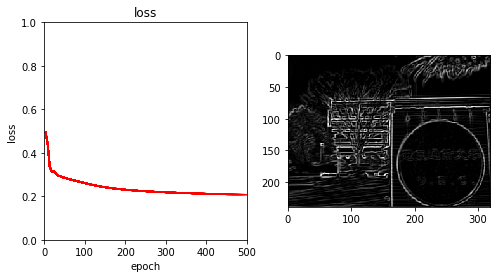

In [10]:
num_epoch=500
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-6)
#optimizer = optim.Adam(model.parameters())
#optimizer = optim.RMSprop(model.parameters())

show_graph=ShowGraph(model,num_epoch,input)
show_graph.on_train_begin();

model.train()

for t in range(num_epoch):
    out = model(input)

    # Compute and print loss.
    loss = loss_fn(out, output)
    if t % 5 == 4:
        show_graph.on_epoch_end(t,loss.item(),out.cpu()) # out.cpu()で結果表示のためにGPUからCPUに戻します．

    # backwardする前に，必ず一度勾配をクリアする．デフォルトでは勾配は足し算される．
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

del show_graph

学習したモデルで画像を変換（エッジ抽出）してみます．

torch.Size([1, 3, 240, 320]) (1, 1, 240, 320)
0.12601542 -1.2311223
0.12601542 -1.0


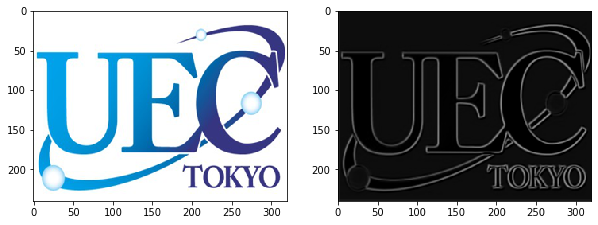

In [11]:
img=np.array(Image.open('image/uec_mark.jpeg').resize((320,240)), dtype=np.float32)
img2=img[np.newaxis,...].transpose(0,3,1,2)
img2=torch.from_numpy(img2/127.5-1.0)
model.eval() # batch normalization, dropoutがある時は，trainとevalの時で挙動が異なるので，モードを切り替えます．

with torch.no_grad():
    out=model(img2.to(device)).cpu().detach().numpy()
print(img2.shape,out.shape)
print(np.max(out),np.min(out))
out=np.clip(out,-1.0,1.0)                   # [-1,1]になるようにclipする．
print(np.max(out),np.min(out))
out=(out+1.0)*127.5                 # 表示するときは，[0..255]に戻します．
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(img/255)  # 値が floatの場合は 値域が [0,1] になるようにします．
plt.subplot(122)
plt.imshow(np.squeeze(out),cmap="gray",vmin=0,vmax=255)
plt.show()

### 課題2
サンプル画像を各自，自分で用意した画像に入れ替えて，以下の小問の(1)-(3)を解答すること．

1. OptimizerをRMSprop, Adamに変更して，モーメンタムSDGとの違いを観察せよ．
1. (1)で最もlossが小さくなったoptimizerを利用して，Batch Normalization Layer を入れた場合と入れない場合で，結果を比較せよ．
    - https://data-analytics.fun/2021/09/11/understanding-batch-normalization/
1. 複数の画像に対応させてみよ．学習画像を2枚, 3枚とするとどうなるか？

loss: 0.3860675096511841
Time:  21.84198570251465


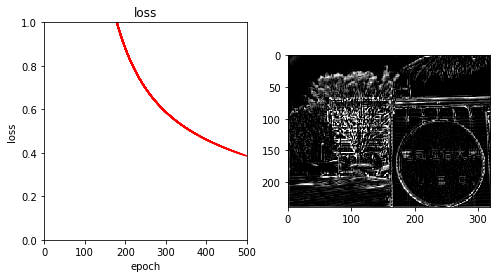

In [12]:
#RMSprop
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
input = input.to(device)
output=output.to(device)

num_epoch=500
loss_fn = nn.MSELoss()
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-6)
#optimizer = optim.Adam(model.parameters())
optimizer = optim.RMSprop(model.parameters())

show_graph=ShowGraph(model,num_epoch,input)
show_graph.on_train_begin();

model.train()

for t in range(num_epoch):
    out = model(input)

    # Compute and print loss.
    loss = loss_fn(out, output)
    if t % 5 == 4:
        show_graph.on_epoch_end(t,loss.item(),out.cpu()) # out.cpu()で結果表示のためにGPUからCPUに戻します．

    # backwardする前に，必ず一度勾配をクリアする．デフォルトでは勾配は足し算される．
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

del show_graph

torch.Size([1, 3, 240, 320]) (1, 1, 240, 320)
0.966658 -2.1640503
0.966658 -1.0


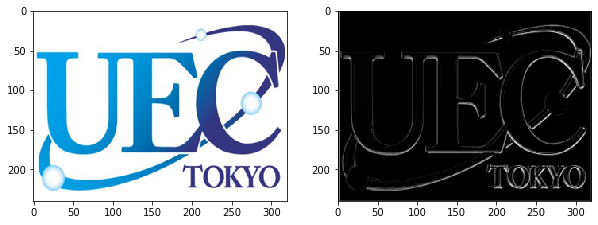

In [13]:
img=np.array(Image.open('image/uec_mark.jpeg').resize((320,240)), dtype=np.float32)
img2=img[np.newaxis,...].transpose(0,3,1,2)
img2=torch.from_numpy(img2/127.5-1.0)
model.eval() # batch normalization, dropoutがある時は，trainとevalの時で挙動が異なるので，モードを切り替えます．

with torch.no_grad():
    out=model(img2.to(device)).cpu().detach().numpy()
print(img2.shape,out.shape)
print(np.max(out),np.min(out))
out=np.clip(out,-1.0,1.0)                   # [-1,1]になるようにclipする．
print(np.max(out),np.min(out))
out=(out+1.0)*127.5                 # 表示するときは，[0..255]に戻します．
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(img/255)  # 値が floatの場合は 値域が [0,1] になるようにします．
plt.subplot(122)
plt.imshow(np.squeeze(out),cmap="gray",vmin=0,vmax=255)
plt.show()

loss: 0.17999257147312164
Time:  22.255172967910767


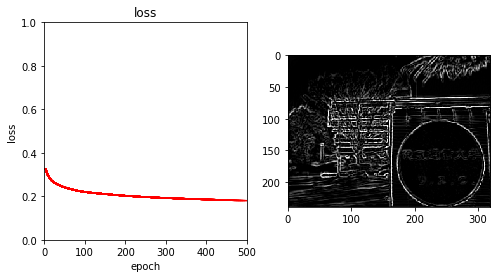

In [14]:
#Adam
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
input = input.to(device)
output=output.to(device)

num_epoch=500
loss_fn = nn.MSELoss()
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-6)
optimizer = optim.Adam(model.parameters())
#optimizer = optim.RMSprop(model.parameters())

show_graph=ShowGraph(model,num_epoch,input)
show_graph.on_train_begin();

model.train()

for t in range(num_epoch):
    out = model(input)

    # Compute and print loss.
    loss = loss_fn(out, output)
    if t % 5 == 4:
        show_graph.on_epoch_end(t,loss.item(),out.cpu()) # out.cpu()で結果表示のためにGPUからCPUに戻します．

    # backwardする前に，必ず一度勾配をクリアする．デフォルトでは勾配は足し算される．
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

del show_graph

torch.Size([1, 3, 240, 320]) (1, 1, 240, 320)
0.87251914 -1.4161562
0.87251914 -1.0


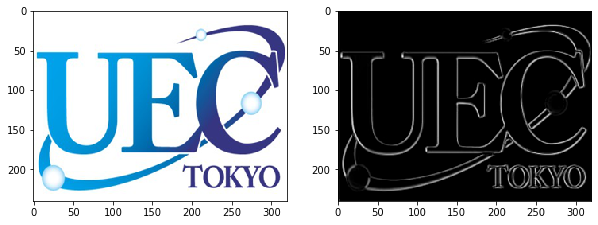

In [15]:
img=np.array(Image.open('image/uec_mark.jpeg').resize((320,240)), dtype=np.float32)
img2=img[np.newaxis,...].transpose(0,3,1,2)
img2=torch.from_numpy(img2/127.5-1.0)
model.eval() # batch normalization, dropoutがある時は，trainとevalの時で挙動が異なるので，モードを切り替えます．

with torch.no_grad():
    out=model(img2.to(device)).cpu().detach().numpy()
print(img2.shape,out.shape)
print(np.max(out),np.min(out))
out=np.clip(out,-1.0,1.0)                   # [-1,1]になるようにclipする．
print(np.max(out),np.min(out))
out=(out+1.0)*127.5                 # 表示するときは，[0..255]に戻します．
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(img/255)  # 値が floatの場合は 値域が [0,1] になるようにします．
plt.subplot(122)
plt.imshow(np.squeeze(out),cmap="gray",vmin=0,vmax=255)
plt.show()

以上、optimizerの比較。Adamが最もよかった。

In [16]:
#c1=Conv(3,3,3,10,pad=1)
#c2=Conv(10,3,3,10,pad=1)
#c3=Conv(10,3,3,1,pad=1,relu=0)

model = nn.Sequential(
    nn.Conv2d(3, 20, 3, padding=1),
    nn.BatchNorm2d(20),
    nn.ReLU(),
    nn.Conv2d(20, 20, 3, padding=1),
    nn.BatchNorm2d(20),
    nn.ReLU(),
    nn.Conv2d(20, 1, 3, padding=1),
)

loss: 0.17895522713661194
Time:  23.491068601608276


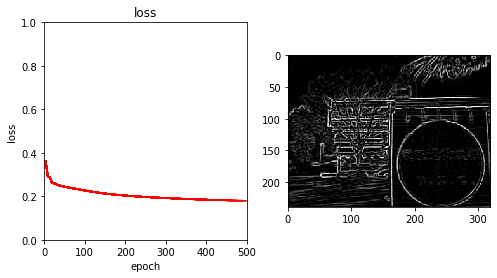

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
input = input.to(device)
output=output.to(device)

num_epoch=500
loss_fn = nn.MSELoss()
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-6)
optimizer = optim.Adam(model.parameters())
#optimizer = optim.RMSprop(model.parameters())

show_graph=ShowGraph(model,num_epoch,input)
show_graph.on_train_begin();

model.train()

for t in range(num_epoch):
    out = model(input)

    # Compute and print loss.
    loss = loss_fn(out, output)
    if t % 5 == 4:
        show_graph.on_epoch_end(t,loss.item(),out.cpu()) # out.cpu()で結果表示のためにGPUからCPUに戻します．

    # backwardする前に，必ず一度勾配をクリアする．デフォルトでは勾配は足し算される．
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

del show_graph

torch.Size([1, 3, 240, 320]) (1, 1, 240, 320)
0.8068532 -1.4552068
0.8068532 -1.0


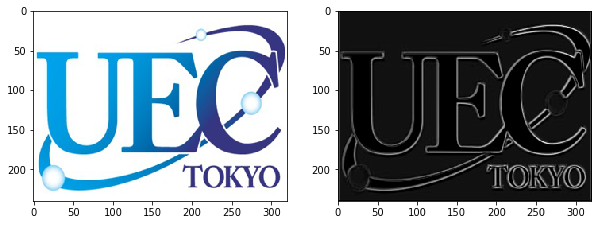

In [18]:
img=np.array(Image.open('image/uec_mark.jpeg').resize((320,240)), dtype=np.float32)
img2=img[np.newaxis,...].transpose(0,3,1,2)
img2=torch.from_numpy(img2/127.5-1.0)
model.eval() # batch normalization, dropoutがある時は，trainとevalの時で挙動が異なるので，モードを切り替えます．

with torch.no_grad():
    out=model(img2.to(device)).cpu().detach().numpy()
print(img2.shape,out.shape)
print(np.max(out),np.min(out))
out=np.clip(out,-1.0,1.0)                   # [-1,1]になるようにclipする．
print(np.max(out),np.min(out))
out=(out+1.0)*127.5                 # 表示するときは，[0..255]に戻します．
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(img/255)  # 値が floatの場合は 値域が [0,1] になるようにします．
plt.subplot(122)
plt.imshow(np.squeeze(out),cmap="gray",vmin=0,vmax=255)
plt.show()

以上、batch normalization layerの追加。
無い場合よりも学習画像以外の場合でよりエッジが明確になったように感じる。

In [1]:
import numpy as np
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# 必要があれば，GPU IDを指定します．
# IEDは 8GPUなので必ず指定してください．
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [2]:
from skimage import feature,filters
from PIL import Image
import os
import sys

%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

In [3]:
# 学習途中のlossなどのグラフ表示を行う ShowGraphを定義
# グラフ表示で必要なので，コンストラクタで，model, 最大エポック数 を受け取っておく．
# model は，学習途中のパラメータを用いて， y=f(x)を描画するのに必要．
class ShowGraph:
    def __init__(self,model,max_epoch,test_img):
        # 表示エリアの設定
        self.fig=plt.figure(figsize=(8,4))
        self.fig1 = self.fig.add_subplot(121)
        self.fig1.axis([0, max_epoch, 0, 1])
        self.fig1.set_title('loss')
        self.fig1.set_ylabel('loss')
        self.fig1.set_xlabel('epoch')
        self.fig2 = self.fig.add_subplot(122)
        self.fig2.axis([-8,8,-10,30])
        self.model=model
        self.max_epoch=max_epoch
        self.test_img=test_img
        self.start=time.time()
    
    # 学習の最初に呼び出される
    def on_train_begin(self, logs={}):
        self.losses=[]
        self.n_epoch=[]
    
    # 各epochの最後に呼び出される
    def on_epoch_end(self, epoch, loss, out):
        #batchを1以上にするときはoutの形に気を付ける
        out = out[0]
        self.n_epoch.append(epoch)
        self.losses.append(loss)
        self.loss=loss
    
        display.clear_output(wait = True)
        self.fig1.plot(self.n_epoch,self.losses,"r") 
        self.out=(out.squeeze()+1.0)*127.5  # 表示するときは，[0.255]に戻します．
        #print out.shape, self.out.shape
        self.fig2.imshow(self.out.detach().numpy(),cmap="gray",vmin=0,vmax=255)
        display.display(self.fig)
        if epoch<self.max_epoch-1:
            self.fig2.cla()

    # デストラクタ(オブジェクトが消滅時に実行される)  
    # グラフが２つ表示されるのを防止．さらに最終val loss値の表示．
    def __del__(self):
        display.clear_output(wait = True)
        print("loss:",self.loss)
        print('Time: ',time.time()-self.start)

In [4]:
#c1=Conv(3,3,3,10,pad=1)
#c2=Conv(10,3,3,10,pad=1)
#c3=Conv(10,3,3,1,pad=1,relu=0)

model = nn.Sequential(
    nn.Conv2d(3, 20, 3, padding=1),
    nn.BatchNorm2d(20),
    nn.ReLU(),
    nn.Conv2d(20, 20, 3, padding=1),
    nn.BatchNorm2d(20),
    nn.ReLU(),
    nn.Conv2d(20, 1, 3, padding=1),
)

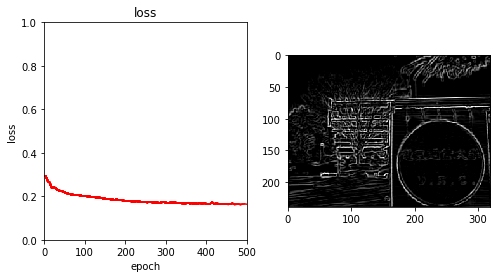

AttributeError: 'ShowGraph' object has no attribute 'on_train_end'

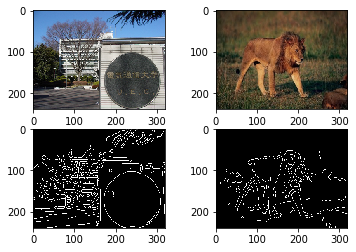

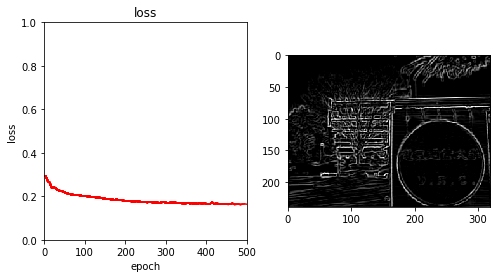

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

img_org1 = Image.open('image/uec.jpeg').resize((320,240))
img1 = np.array(img_org1, dtype=np.uint8)
gray1 = np.array(img_org1.convert('L'), dtype=np.uint8)
edge1 = feature.canny(gray1,sigma=2)
edge1 = edge1 * 255

img_org2 = Image.open('image/lion.jpeg').resize((320,240))
img2 = np.array(img_org2, dtype=np.uint8)
gray2 = np.array(img_org2.convert('L'), dtype=np.uint8)
edge2 = feature.canny(gray2,sigma=2)
edge2= edge2* 255

use_edge=True
if use_edge:
    gt1=edge1
    gt2=edge2
else:
    gt1=grey1
    gt2=grey2

plt.subplot(221)
plt.imshow(img1)
plt.subplot(222)
plt.imshow(img2)
plt.subplot(223)
plt.imshow(gt1,cmap="gray")
plt.subplot(224)
plt.imshow(gt2,cmap="gray")

img1=img1.transpose(2,0,1)
gt1=gt1[np.newaxis, ...]
img2=img2.transpose(2,0,1)
gt2=gt2[np.newaxis, ...]

input1  = (np.asarray(img1, dtype=np.float32)-127.5)/127.5
output1 = (np.asarray(gt1, dtype=np.float32)-127.5)/127.5
input2  = (np.asarray(img2, dtype=np.float32)-127.5)/127.5
output2 = (np.asarray(gt2, dtype=np.float32)-127.5)/127.5

print(np.vstack([input1[np.newaxis, ...],input2[np.newaxis, ...]]).shape)
input = torch.from_numpy(np.vstack([input1[np.newaxis, ...],input2[np.newaxis, ...]]))
output = torch.from_numpy(np.vstack([output1[np.newaxis, ...],output2[np.newaxis, ...]]))

model = nn.Sequential(
    nn.Conv2d(3, 20, 3, padding=1), # 入力はカラー画像(RGB)なので 3チャネル
    nn.ReLU(),
    nn.Conv2d(20, 20, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(20, 1, 3, padding=1),
)

model = model.to(device)
input = input.to(device)
output=output.to(device)

num_epoch=500
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-6)

show_graph=ShowGraph(model,num_epoch,input)
show_graph.on_train_begin();

model.train()

for t in range(num_epoch):
    out = model(input)

    # Compute and print loss.
    loss = loss_fn(out, output)
    if t % 5 == 4:
        show_graph.on_epoch_end(t,loss.item(),out.cpu()[0])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

show_graph.on_train_end()

In [ ]:
img=np.array(Image.open('image/uec_mark.jpeg').resize((320,240)), dtype=np.float32)
img2=img[np.newaxis,...].transpose(0,3,1,2)
img2=torch.from_numpy(img2/127.5-1.0)
model.eval() # batch normalization, dropoutがある時は，trainとevalの時で挙動が異なるので，モードを切り替えます．

with torch.no_grad():
    out=model(img2.to(device)).cpu().detach().numpy()
print(img2.shape,out.shape)
print(np.max(out),np.min(out))
out=np.clip(out,-1.0,1.0)                   # [-1,1]になるようにclipする．
print(np.max(out),np.min(out))
out=(out+1.0)*127.5                 # 表示するときは，[0..255]に戻します．
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(img/255)  # 値が floatの場合は 値域が [0,1] になるようにします．
plt.subplot(122)
plt.imshow(np.squeeze(out),cmap="gray",vmin=0,vmax=255)
plt.show()